In [ ]:
!pip install chronos-forecasting
import pandas as pd  # requires: pip install pandas
import numpy as np
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt

: 

In [10]:
#Choose Device
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device")

Using cuda device


# Testing base chronos model on Chaotic Systems

- Chronos outputs am evenly spaced quantile prediction at {0.1, 0.2, ... 0.9}
- WqL: input all quantiles -> outputs a loss value
- MASE: input a single quantile (standardize at 0.5) -> outputs a loss value

In [11]:
#WQL FUNCTION (Sourced from chatGPT)


def quantile_loss(y_true, y_pred, alpha):
    """
    Computes quantile loss for a given quantile level alpha.
    
    Parameters:
    - y_true: True values (numpy array of shape (N,))
    - y_pred: Predicted quantile values (numpy array of shape (N,))
    - alpha: Quantile level (scalar)

    Returns:
    - Quantile loss (scalar)
    """
    diff = y_true - y_pred
    return np.maximum(alpha * diff, (alpha - 1) * diff).mean()

def weighted_quantile_loss(y_true, y_pred_quantiles, quantile_levels):
    """
    Computes the Weighted Quantile Loss (WQL) with the modified shape of predictions.

    Parameters:
    - y_true: True values (numpy array of shape (N,))
    - y_pred_quantiles: Predicted quantiles (numpy array of shape (K, N), where K is the number of quantiles)
    - quantile_levels: List or array of quantile levels (K,)

    Returns:
    - Weighted Quantile Loss (scalar)
    """
    assert y_pred_quantiles.shape[0] == len(quantile_levels), "Mismatch in quantile dimensions"

    # Compute WQL for each quantile
    wql_per_quantile = [
        (2 * quantile_loss(y_true, y_pred_quantiles[j, :], alpha)) / np.abs(y_true).sum()
        for j, alpha in enumerate(quantile_levels)
    ]
    
    # Final WQL (mean over quantiles)
    return np.mean(wql_per_quantile)

In [12]:
#MASE 
def mase(y_true, y_pred, y_past, S):
    """
    Computes the Mean Absolute Scaled Error (MASE) based on the provided formula.

    Parameters:
    - y_true: Actual values (numpy array of shape (H,))
    - y_pred: Predicted values (numpy array of shape (H,))
    - y_past: Historical values (numpy array of shape (C,)) for computing seasonal naive MAE
    - S: Seasonality parameter (integer)

    Returns:
    - MASE score (scalar)
    """
    C = len(y_past)  # Context length
    H = len(y_true)  # Prediction horizon

    # Compute the numerator (MAE of forecast)
    numerator = np.sum(np.abs(y_pred - y_true)) / H

    # Compute the denominator (MAE of seasonal naive forecast)
    denominator = np.sum(np.abs(y_past[:-S] - y_past[S:])) / (C - S)

    return numerator / denominator if denominator != 0 else np.inf

In [13]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-mini",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# Chronos-Bolt models generate quantile forecasts, so forecast has shape
# [num_series, num_quantiles, prediction_length].
forecast = pipeline.predict(
    context=torch.tensor(df["#Passengers"].iloc[:-12]), prediction_length=12
)

In [14]:
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


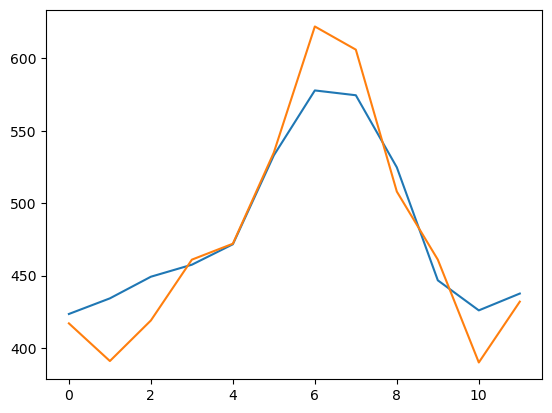

In [15]:
plt.plot(forecast[0][4],label='forecast')
plt.plot(df["#Passengers"].iloc[-12:].to_numpy())

In [17]:
quantiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
weighted_quantile_loss(df["#Passengers"].iloc[-12:].to_numpy(), forecast[0].numpy(), quantiles)

0.002806450351724039

In [16]:
mase(df["#Passengers"].iloc[-12:].to_numpy(), forecast[0][4].numpy(), df["#Passengers"].iloc[:-12].to_numpy(), 12)

0.6404895500596521

## Test with BATS dataset

In [18]:
df = pd.read_csv('Data/BATS_cleaned.csv')
df.head()

,Unnamed: 0,YearMonth,Total_dry/vol_norm
0,0,1994-04,167.247222
1,1,1994-05,151.395000
2,2,1994-06,243.672500
3,3,1994-07,219.662500
4,4,1994-08,320.070000


In [19]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# Chronos-Bolt models generate quantile forecasts, so forecast has shape
# [num_series, num_quantiles, prediction_length].
forecast = pipeline.predict(
    context=torch.tensor(df["Total_dry/vol_norm"].iloc[:-60]), prediction_length=60
)

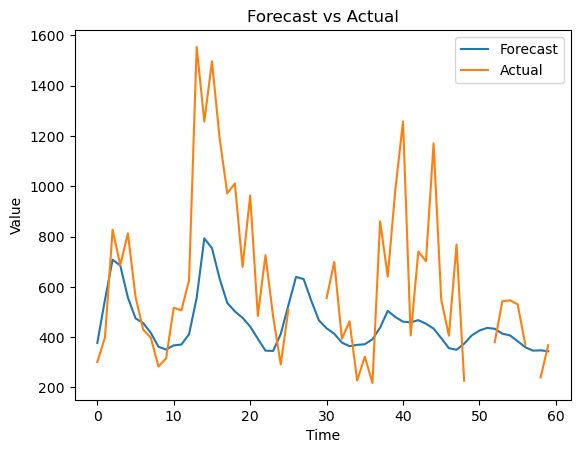

In [20]:
plt.plot(forecast[0][4], label='Forecast') 
plt.plot(df["Total_dry/vol_norm"].iloc[-60:].to_numpy(), label='Actual')  

plt.legend()  
plt.xlabel("Time") 
plt.ylabel("Value")  
plt.title("Forecast vs Actual") 

plt.show()

## Test with RIU

In [21]:
df = pd.read_csv('Data/RIU_cleaned.csv')
df.head()

,Unnamed: 0,YearMonth,Total abundance
0,0,1999-01,124000.0
1,1,1999-02,119750.0
2,2,1999-03,198300.0
3,3,1999-04,1595075.0
4,4,1999-05,1199800.0


In [22]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# Chronos-Bolt models generate quantile forecasts, so forecast has shape
# [num_series, num_quantiles, prediction_length].
forecast = pipeline.predict(
    context=torch.tensor(df["Total abundance"].iloc[:-60]), prediction_length=60
)

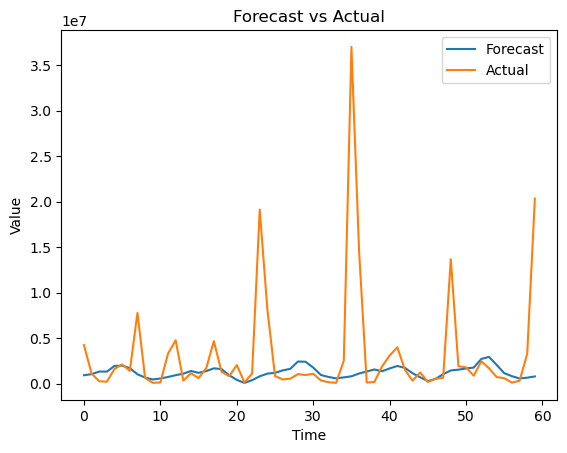

In [23]:
plt.plot(forecast[0][4], label='Forecast') 
plt.plot(df["Total abundance"].iloc[-60:].to_numpy(), label='Actual')  

plt.legend()  
plt.xlabel("Time") 
plt.ylabel("Value")  
plt.title("Forecast vs Actual") 

plt.show()

## Testing on Oneida lake data

In [24]:
df = pd.read_csv('Data/oneida-diaptomus.csv')
df.head()

,Unnamed: 0,rounded-date,ABUNDANCE,BIOMAS
0,0,1979-02-01,0.280000,1.680000
1,1,1979-03-01,NaN,NaN
2,2,1979-04-01,0.405000,3.740000
3,3,1979-05-01,5.925000,33.490000
4,4,1979-06-01,8.958571,46.118571


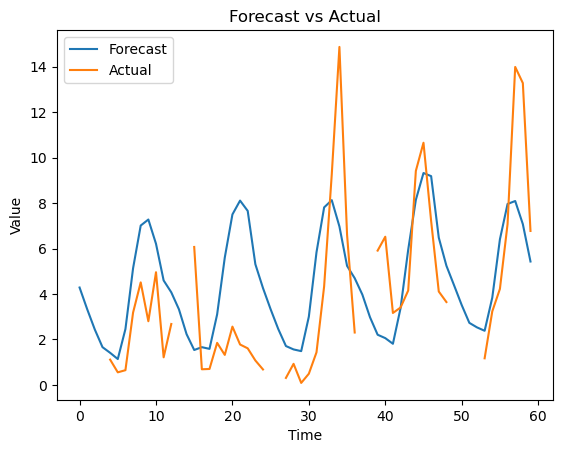

In [31]:
forecast = pipeline.predict(
    context=torch.tensor(df["ABUNDANCE"].iloc[:-60]), prediction_length=60
)
plt.plot(forecast[0][4], label='Forecast') 
plt.plot(df["ABUNDANCE"].iloc[-60:].to_numpy(), label='Actual')  

plt.legend()  
plt.xlabel("Time") 
plt.ylabel("Value")  
plt.title("Forecast vs Actual") 

plt.show()

In [35]:
df = pd.read_csv('Data/marine-flagellate sp4.csv')
df

,Unnamed: 0,rounded-date,ABUNDANCE
0,0,1995-03-27,2076.592500
1,1,1995-04-03,902.756667
2,2,1995-04-10,2171.155000
3,3,1995-04-17,NaN
4,4,1995-04-24,NaN
...,...,...,...
340,340,2001-10-01,NaN
341,341,2001-10-08,3252.950000
342,342,2001-10-15,NaN
343,343,2001-10-22,2678.010000


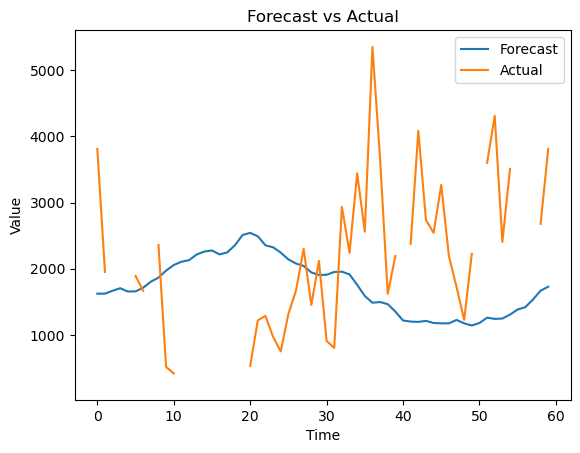

In [36]:
forecast = pipeline.predict(
    context=torch.tensor(df["ABUNDANCE"].iloc[:-60]), prediction_length=60
)
plt.plot(forecast[0][4], label='Forecast') 
plt.plot(df["ABUNDANCE"].iloc[-60:].to_numpy(), label='Actual')  

plt.legend()  
plt.xlabel("Time") 
plt.ylabel("Value")  
plt.title("Forecast vs Actual") 

plt.show()